# PROJECT: DỰ BÁO TẢI ĐIỆN VN Part 2



1. [III. Predictive modeling](#1)
1. [IV. Evaluation](#2)

<a id="1"></a>
## III. Predictive modeling


### Prepare data

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import tensorflow as tf
import xgboost as xgb
import os
import warnings
from tensorflow.keras.layers import Dense, LSTM, Conv1D, MaxPooling1D, TimeDistributed, Flatten, Dropout, RepeatVector
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller, kpss, ccf
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from math import sqrt
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler

import numpy as np
np.seterr(divide='ignore', invalid='ignore')
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from numpy import inf

df_load = pd.read_csv('Feature_Engineering.csv')
df_load = df_load.drop('Unnamed: 0', axis=1)

def multivariate_data(dataset, target, start_index, end_index, history_size,
                      target_size, step, single_step=False):
    data = []
    labels = []

    start_index = start_index + history_size
    if end_index is None:
        end_index = len(dataset) - target_size
        
    for i in range(start_index, end_index):
        indices = range(i-history_size, i, step)
        data.append(dataset[indices])
        
        if single_step:
            labels.append(target[i + target_size])
        else:
            labels.append(target[i : i + target_size])

    return np.array(data), np.array(labels)

def tranform_data(X, y):
    y = y.reshape(-1, 1)
    
    scaler_X = MinMaxScaler(feature_range=(0, 1))
    scaler_y = MinMaxScaler(feature_range=(0, 1))

    scaler_X.fit(X)
    scaler_y.fit(y)
    
    X_norm = scaler_X.transform(X)
    y_norm = scaler_y.transform(y)
    
    return X_norm, y_norm, scaler_y

def load_all_data(df_load):
    # For all data
    X = df_load[df_load.columns.drop(['using_daily','customer_id', 'meter_id','Time', 'source'])].values
    y = df_load['using_daily'].values

    train_end_idx = int(y.shape[0]*0.6) # 80% train 20% validation
    cv_end_idx = train_end_idx + int(y.shape[0]*0.2)
    test_end_idx = y.shape[0]

    X_norm, y_norm, scaler_y = tranform_data(X, y)

    pca = PCA(n_components=0.70)
    pca.fit(X_norm)
    X_pca = pca.transform(X_norm)

    dataset_norm = np.concatenate((X_pca, y_norm), axis=1)

    past_history = 1
    future_target = 0

    # dataset_norm.shape

    X_train, y_train = multivariate_data(dataset_norm, dataset_norm[:, -1],
                                         0, train_end_idx, past_history, 
                                         future_target, step=1, single_step=True)

    X_val, y_val = multivariate_data(dataset_norm, dataset_norm[:, -1],
                                     train_end_idx, cv_end_idx, past_history, 
                                     future_target, step=1, single_step=True)

    X_test, y_test = multivariate_data(dataset_norm, dataset_norm[:, -1],
                                       cv_end_idx, test_end_idx, past_history, 
                                       future_target, step=1, single_step=True)

    batch_size = 32
    buffer_size = 1000

    train = tf.data.Dataset.from_tensor_slices((X_train, y_train))
    train = train.cache().shuffle(buffer_size).batch(batch_size).prefetch(1)

    validation = tf.data.Dataset.from_tensor_slices((X_val, y_val))
    validation = validation.batch(batch_size).prefetch(1)

    

    y_test = y_test.reshape(-1, 1)
    y_test_inv = scaler_y.inverse_transform(y_test)
    
    return [X_train, y_train, X_val, y_val, X_test, y_test_inv], [train, validation], scaler_y

def load_train_test(df_load):
    # load train/test from source
    
    X = df_load[df_load['source']=='train'][df_load.columns.drop(['using_daily','customer_id', 'meter_id','Time', 'source'])].values
    y = df_load[df_load['source']=='train']['using_daily'].values
    X_train, y_train, _ = tranform_data(X, y)
    
    ##########################################
    
    X_test = df_load[df_load['source']=='test'][df_load.columns.drop(['using_daily','customer_id', 'meter_id','Time', 'source'])].values
    y_test = df_load[df_load['source']=='test']['using_daily'].values
    X_test, y_test, _ = tranform_data(X_test, y_test)
    
    ##########################################
    
    return X_train, y_train, X_test, y_test

### Hyperparameters

In [2]:
loss = tf.keras.losses.MeanSquaredError()
metric = [tf.keras.metrics.RootMeanSquaredError()]
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
              lambda epoch: 1e-4 * 10**(epoch / 10))
early_stopping = tf.keras.callbacks.EarlyStopping(patience=10)

batch_size = 64
buffer_size = 1000


### Function loss viewer

In [3]:
def plot_predict(y_test, y_pred, case = 1):

    if case == 1:
        plt.figure(figsize=(10,10))
        plt.scatter(y_test, y_pred, c='crimson')
        plt.yscale('log')
        plt.xscale('log')

        p1 = max(max(y_test), max(y_pred))
        p2 = min(min(y_test), min(y_pred))
        plt.plot([p1, p2], [p1, p2], 'b-')
        plt.xlabel('True Values', fontsize=15)
        plt.ylabel('Predictions', fontsize=15)
        plt.axis('equal')
        plt.show()
    if case == 2:
        plt.figure(figsize=(10,10))
        plt.plot(y_test[:500])
        plt.plot( y_pred[:500])
        plt.show()
        
def plot_model_rmse_and_loss(history):
    
    # Evaluate train and validation accuracies and losses
    
    train_rmse = history.history['root_mean_squared_error']
    val_rmse = history.history['val_root_mean_squared_error']
    
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    # Visualize epochs vs. train and validation accuracies and losses
    
    plt.figure(figsize=(20, 10))
    plt.subplot(1, 2, 1)
    plt.plot(train_rmse, label='Training RMSE')
    plt.plot(val_rmse, label='Validation RMSE')
    plt.legend()
    plt.title('Epochs vs. Training and Validation RMSE')
    
    plt.subplot(1, 2, 2)
    plt.plot(train_loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.legend()
    plt.title('Epochs vs. Training and Validation Loss')
    
    plt.show()

def print_metrics( y_test, y_predict, model_name='abc'):
    r2 = r2_score(y_test, y_predict)
    print('r2 of {}: {}'.format(model_name, round(r2, 3)))

    mae = mean_absolute_error(y_test, y_predict)
    print('MAE of {}: {}'.format(model_name, round(mae, 3)))

    rmse = sqrt(mean_squared_error(y_test, y_predict))
    print('RMSE of {}: {}'.format(model_name, round(rmse, 3)))

    error = (y_predict - y_test)*100/y_test
    error[error == inf] = 0
    LOSS = error.mean()
    print('LOSS of {}: {}'.format(model_name, round(LOSS, 3)))

    error = (y_predict - y_test)*100/y_test
    error[error == inf] = 0
    positive_LOSS = error[error>0].mean()
    print('POSITIVE LOSS of {}: {}'.format(model_name, round(positive_LOSS, 3)))

    error = (y_predict - y_test)*100/y_test
    error[error == inf] = 0
    negative_LOSS = error[error<0].mean()
    print('NEGATIVE LOSS of {}: {}'.format(model_name, round(negative_LOSS, 3)))

    # error[error!=0].mean()


## Model
+ Random Forest Regressor
+ Support Vector Regression
+ XGBoot
+ LSTM
+ CNN

### Random Forest Regressor

In [4]:
X_train, y_train, X_test, y_test  = load_train_test(df_load)

In [5]:
from sklearn.feature_selection import SelectKBest
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import make_pipeline
import numpy as np

forest = make_pipeline(
    SelectKBest(k="all"),
    StandardScaler(),
    RandomForestRegressor(
        n_estimators=100,
        max_depth=50,
        random_state=77,
        n_jobs=-1
    )
)
forest.fit(X_train, y_train)

y_pred_Forest = forest.predict(X_test)

print_metrics(y_test, y_pred_Forest, model_name='Random Forest')

/opt/anaconda3/envs/doanhpv-python37/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/anaconda3/envs/doanhpv-python37/lib/python3.7/site-packages/sklearn/pipeline.py:356: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


r2 of Random Forest: 0.197
MAE of Random Forest: 0.095
RMSE of Random Forest: 0.134
LOSS of Random Forest: 587.612
POSITIVE LOSS of Random Forest: 1081.247
NEGATIVE LOSS of Random Forest: -47.233


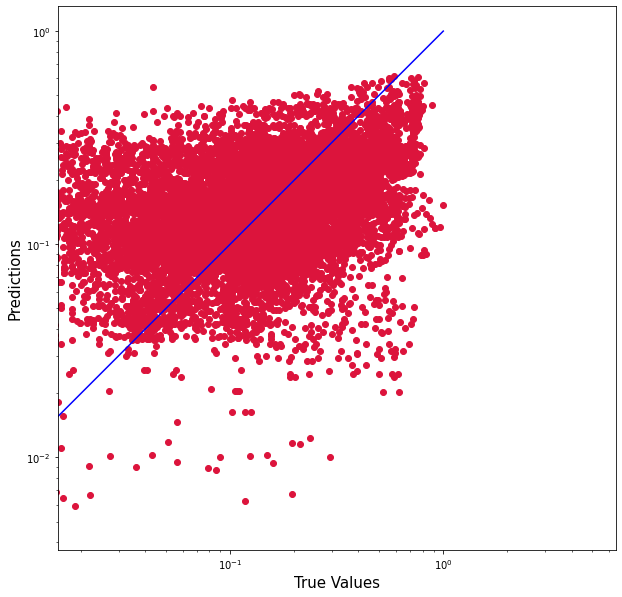

In [6]:
plot_predict(y_test, y_pred_Forest, case = 1)

### SVR

- Ref:[Support Vector Regression](https://scikit-learn.org/stable/auto_examples/svm/plot_svm_regression.html#sphx-glr-auto-examples-svm-plot-svm-regression-py)


In [7]:
X_train, y_train, X_test, y_test  = load_train_test(df_load)

In [8]:
from sklearn import svm

regr = svm.SVR()
regr.fit(X_train, y_train)

regr.predict(X_test)

y_pred_svr=regr.predict(X_test)
print_metrics(y_test, y_pred_svr, model_name='SVR')

/opt/anaconda3/envs/doanhpv-python37/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/anaconda3/envs/doanhpv-python37/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


r2 of SVR: 0.086
MAE of SVR: 0.099
RMSE of SVR: 0.143
LOSS of SVR: 548.048
POSITIVE LOSS of SVR: 954.705
NEGATIVE LOSS of SVR: -41.967


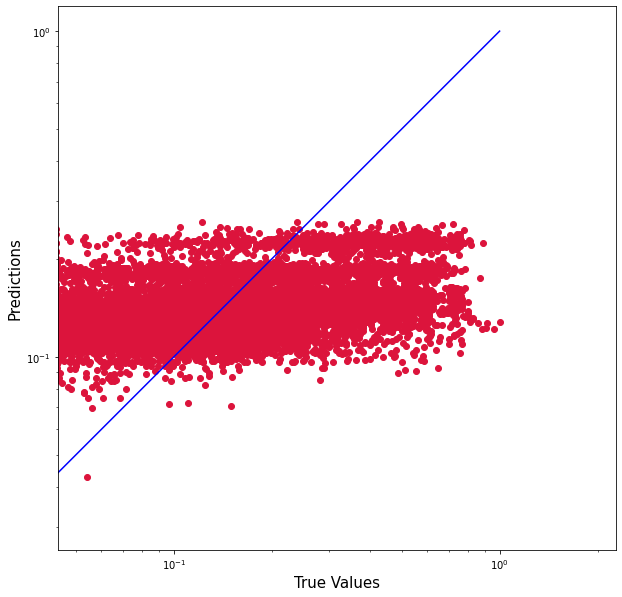

In [9]:
plot_predict(y_test, y_pred_svr, case = 1)

### XGBoot

Ref:
- [Time Series forecasting with XGBoost](https://www.kaggle.com/code/robikscube/tutorial-time-series-forecasting-with-xgboost)

- [xgboost-for-regression](https://machinelearningmastery.com/xgboost-for-regression/)


In [10]:
[X_train, y_train, X_val, y_val, X_test, y_test_inv], [train, validation], scaler_y  = load_all_data(df_load)

In [11]:
import xgboost as xgb
from xgboost import plot_importance, plot_tree

X_train_xgb = X_train.reshape(-1, X_train.shape[1] * X_train.shape[2])
X_val_xgb = X_val.reshape(-1, X_val.shape[1] * X_val.shape[2])
X_test_xgb = X_test.reshape(-1, X_test.shape[1] * X_test.shape[2])

param = {'eta': 0.03, 'max_depth': 180, 
         'subsample': 1.0, 'colsample_bytree': 0.95, 
         'alpha': 0.1, 'lambda': 0.15, 'gamma': 0.1,
         'objective': 'reg:linear', 'eval_metric': 'rmse', 
         'silent': 1, 'min_child_weight': 0.1, 'n_jobs': -1}

dtrain = xgb.DMatrix(X_train_xgb, y_train)
dval = xgb.DMatrix(X_val_xgb, y_val)
eval_list = [(dtrain, 'train'), (dval, 'eval')]

xgb_model = xgb.train(param, dtrain, 25, eval_list, early_stopping_rounds=3)


[17:13:42] WARNING: ../src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[17:13:42] WARNING: ../src/learner.cc:573: 
Parameters: { "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	train-rmse:0.37232	eval-rmse:0.35732
[1]	train-rmse:0.36254	eval-rmse:0.34898
[2]	train-rmse:0.35312	eval-rmse:0.34085
[3]	train-rmse:0.34399	eval-rmse:0.33315
[4]	train-rmse:0.33518	eval-rmse:0.32572
[5]	train-rmse:0.32666	eval-rmse:0.31826
[6]	train-rmse:0.31842	eval-rmse:0.31043
[7]	train-rmse:0.31049	eval-rmse:0.30316
[8]	train-rmse:0.30285	eval-rmse:0.29614
[9]	train-rmse:0.29545	eval-rmse:0.29015
[10]	train-rmse:0.28826	eval-rmse:0.28343
[11]	train-rmse:0.28138	eval-rmse:0.27783
[12]	train-rmse:0.27464	eval-rmse:0.27272
[13]	train-rmse:0

In [12]:
dtest = xgb.DMatrix(X_test_xgb, y_test_inv)
forecast = xgb_model.predict(dtest)
xgb_forecast = forecast.reshape(-1, 1)

xgb_forecast_inv = scaler_y.inverse_transform(xgb_forecast)

print_metrics(y_test_inv, xgb_forecast_inv, model_name='XGBoot')


r2 of XGBoot: -1.667
MAE of XGBoot: 15.844
RMSE of XGBoot: 17.145
LOSS of XGBoot: 1580.931
POSITIVE LOSS of XGBoot: 1785.671
NEGATIVE LOSS of XGBoot: -27.002


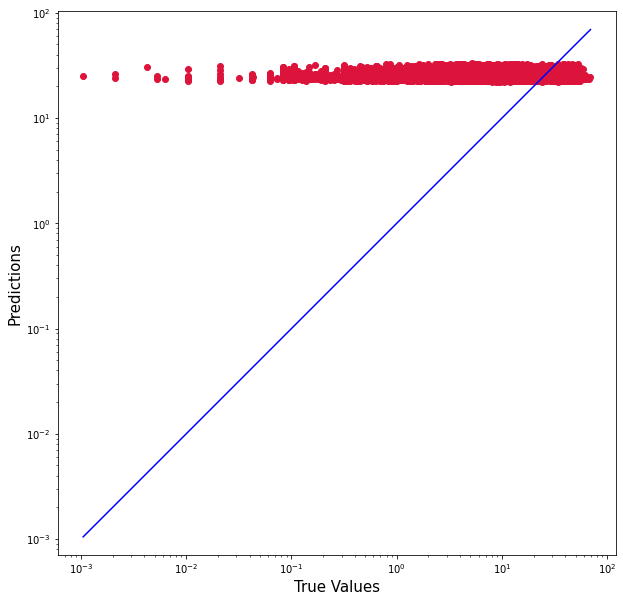

In [13]:
plot_predict(y_test_inv, xgb_forecast_inv, case = 1)

### LSTM

Ref: [Time_Series_Prediction_with_LSTM_Using_PyTorch](https://github.com/spdin/time-series-prediction-lstm-pytorch/blob/master/Time_Series_Prediction_with_LSTM_Using_PyTorch.ipynb)


In [14]:
[X_train, y_train, X_val, y_val, X_test, y_test_inv], [train, validation], scaler_y  = load_all_data(df_load)

Epoch 1/25
1690/1690 [==============================] - 14s 9ms/step - loss: 0.0176 - root_mean_squared_error: 0.1326 - val_loss: 0.0000e+00 - val_root_mean_squared_error: 0.0000e+00
Epoch 2/25
1690/1690 [==============================] - 10s 6ms/step - loss: 0.0175 - root_mean_squared_error: 0.1322 - val_loss: 0.0173 - val_root_mean_squared_error: 0.1315
Epoch 3/25
1690/1690 [==============================] - 10s 6ms/step - loss: 0.0175 - root_mean_squared_error: 0.1322 - val_loss: 0.0173 - val_root_mean_squared_error: 0.1315
Epoch 4/25
1690/1690 [==============================] - 10s 6ms/step - loss: 0.0175 - root_mean_squared_error: 0.1323 - val_loss: 0.0174 - val_root_mean_squared_error: 0.1318
Epoch 5/25
1690/1690 [==============================] - 8s 5ms/step - loss: 0.0175 - root_mean_squared_error: 0.1322 - val_loss: 0.0173 - val_root_mean_squared_error: 0.1315
Epoch 6/25
1690/1690 [==============================] - 10s 6ms/step - loss: 0.0175 - root_mean_squared_error: 0.1323 

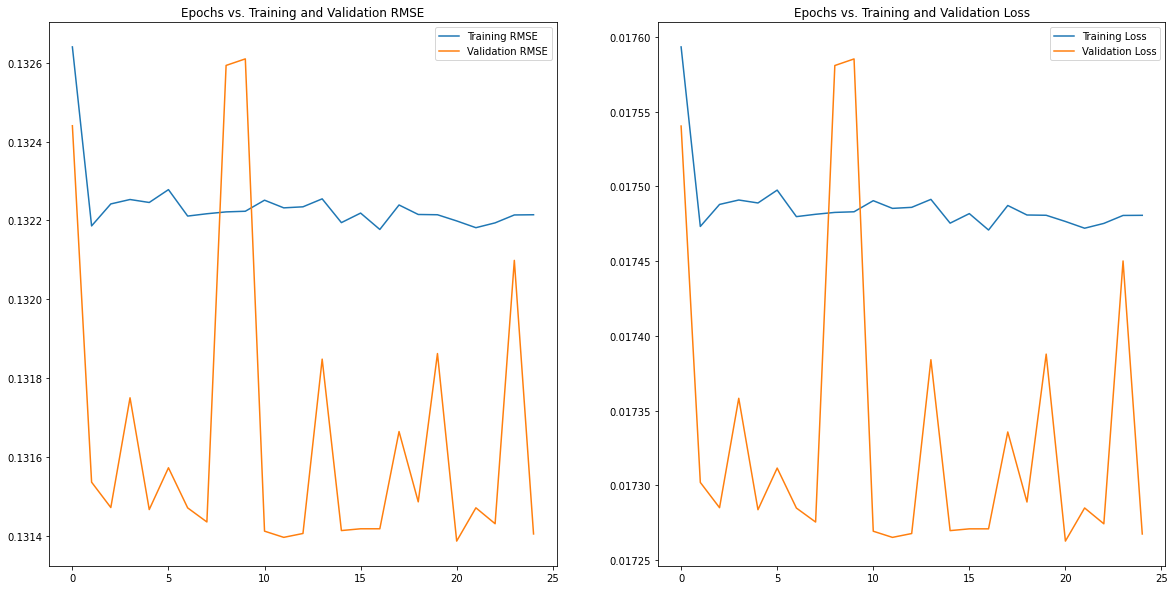

In [15]:
from tensorflow.keras.layers import Dense, LSTM, Conv1D, MaxPooling1D, TimeDistributed, Flatten, Dropout, RepeatVector

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
from torch.autograd import Variable
from sklearn.preprocessing import MinMaxScaler


tf.keras.backend.clear_session()

input_shape = X_train.shape[-2:]
multivariate_lstm = tf.keras.models.Sequential([
    LSTM(100, input_shape=input_shape, 
         return_sequences=True),
    Flatten(),
    Dense(200, activation='relu'),
    Dropout(0.1),
    Dense(1)
])

model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
                   'multivariate_lstm.h5', monitor=('val_loss'), save_best_only=True)
optimizer = tf.keras.optimizers.Adam(lr=6e-3, amsgrad=True)

multivariate_lstm.compile(loss=loss,
                          optimizer=optimizer,
                          metrics=metric)

history = multivariate_lstm.fit(train, epochs=25,
                                validation_data=validation,
                                callbacks=[early_stopping, 
                                           model_checkpoint])

plot_model_rmse_and_loss(history)

In [16]:
multivariate_lstm = tf.keras.models.load_model('multivariate_lstm.h5')

forecast = multivariate_lstm.predict(X_test)
lstm_forecast = scaler_y.inverse_transform(forecast)

print_metrics( y_test_inv, lstm_forecast, model_name='LSTM')

r2 of LSTM: -0.009
MAE of LSTM: 8.083
RMSE of LSTM: 10.545
LOSS of LSTM: 730.797
POSITIVE LOSS of LSTM: 1083.515
NEGATIVE LOSS of LSTM: -38.867


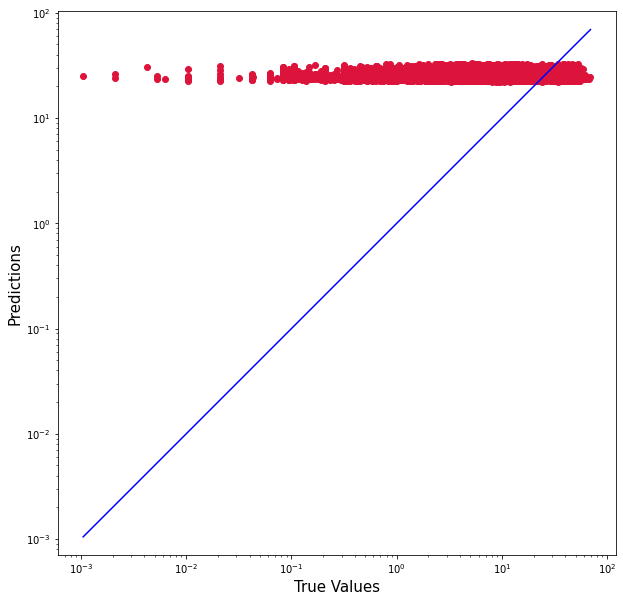

In [17]:
plot_predict(y_test_inv, xgb_forecast_inv, case = 1)

### CNN

In [18]:
[X_train, y_train, X_val, y_val, X_test, y_test_inv], [train, validation], scaler_y  = load_all_data(df_load)

Epoch 1/25
1690/1690 [==============================] - 5s 3ms/step - loss: 0.0177 - root_mean_squared_error: 0.1329 - val_loss: 0.0000e+00 - val_root_mean_squared_error: 0.0000e+00
Epoch 2/25
1690/1690 [==============================] - 6s 3ms/step - loss: 0.0175 - root_mean_squared_error: 0.1322 - val_loss: 0.0174 - val_root_mean_squared_error: 0.1320
Epoch 3/25
1690/1690 [==============================] - 3s 2ms/step - loss: 0.0175 - root_mean_squared_error: 0.1322 - val_loss: 0.0173 - val_root_mean_squared_error: 0.1314
Epoch 4/25
1690/1690 [==============================] - 3s 2ms/step - loss: 0.0175 - root_mean_squared_error: 0.1322 - val_loss: 0.0173 - val_root_mean_squared_error: 0.1314
Epoch 5/25
1690/1690 [==============================] - 5s 3ms/step - loss: 0.0175 - root_mean_squared_error: 0.1322 - val_loss: 0.0174 - val_root_mean_squared_error: 0.1320
Epoch 6/25
1690/1690 [==============================] - 3s 2ms/step - loss: 0.0175 - root_mean_squared_error: 0.1322 - val

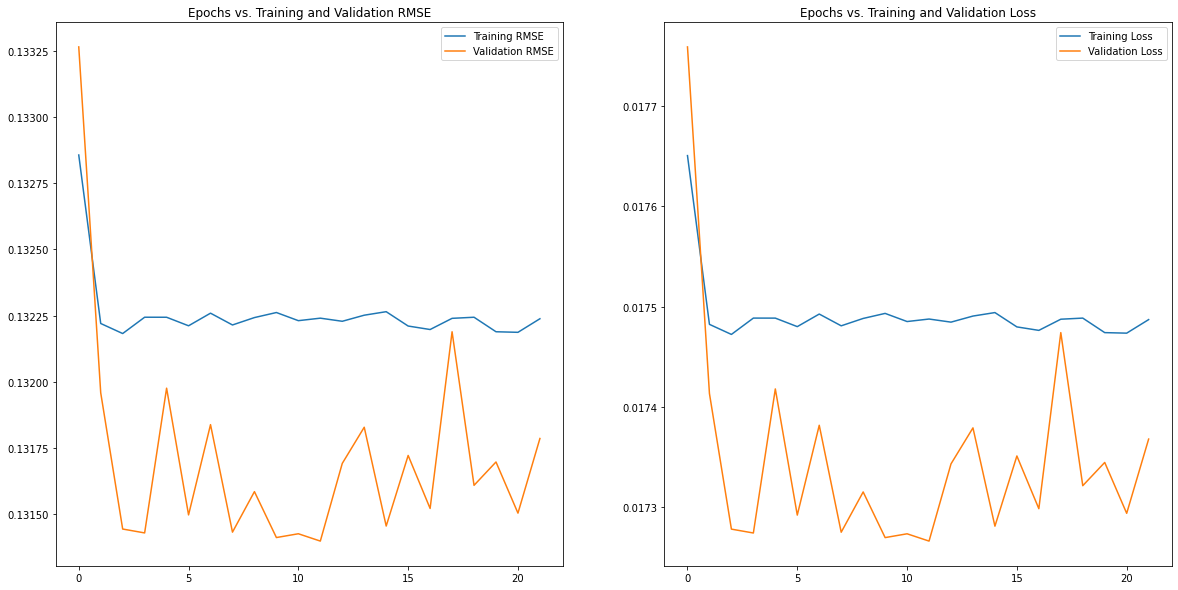

In [19]:
tf.keras.backend.clear_session()

input_shape = X_train.shape[-2:]
multivariate_cnn = tf.keras.models.Sequential([
    Conv1D(filters=48, kernel_size=2,
           strides=1, padding='causal',
           activation='relu', 
           input_shape=input_shape),
    Flatten(),
    Dense(48, activation='relu'),
    Dense(1)
])

model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
                   'multivariate_cnn.h5', save_best_only=True)
optimizer = tf.keras.optimizers.Adam(lr=6e-3, amsgrad=True)

multivariate_cnn.compile(loss=loss,
                          optimizer=optimizer,
                          metrics=metric)


history = multivariate_cnn.fit(train, epochs=25,
                                validation_data=validation,
                                callbacks=[early_stopping, 
                                           model_checkpoint])

plot_model_rmse_and_loss(history)

In [20]:
multivariate_cnn = tf.keras.models.load_model('multivariate_cnn.h5')

forecast = multivariate_cnn.predict(X_test)
multivariate_cnn_forecast = scaler_y.inverse_transform(forecast)

print_metrics(y_test_inv, forecast, model_name='XGBoot')

r2 of XGBoot: -1.11
MAE of XGBoot: 11.064
RMSE of XGBoot: 15.251
LOSS of XGBoot: -89.435
POSITIVE LOSS of XGBoot: 350.915
NEGATIVE LOSS of XGBoot: -95.581


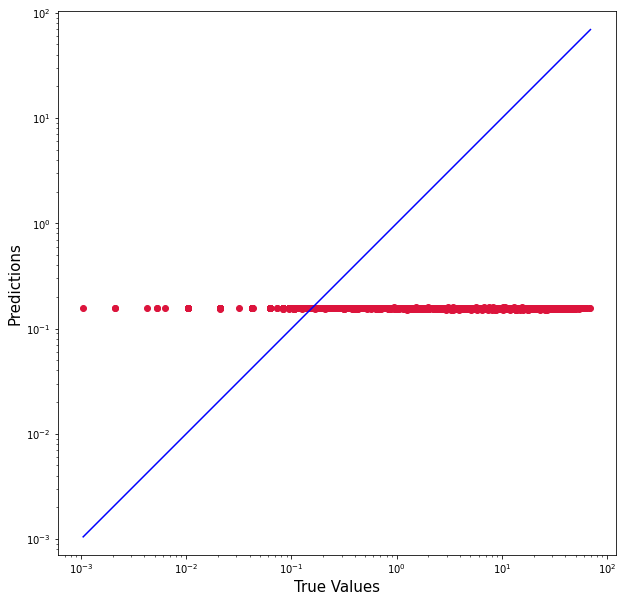

In [21]:
plot_predict(y_test_inv, forecast, case = 1)